In [2]:
#libraries for modeling
from multiprocessing.pool import ThreadPool
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession, Window, Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
import itertools
from itertools import repeat
import pickle
import pyspark
import copy

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#libraries for plotting
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class CreateBestModel:
    def __init__(self, algo, avgprecision, avgrecall, avgfscore, hyperparams, ootmodel, ootprecision, ootrecall, ootfscore):
        self.algo = algo
        self.gsPrecision = avgprecision
        self.gsFScore = avgfscore
        self.gsRecall = avgrecall
        self.hyperParams = hyperparams
        self.model = ootmodel
        self.ootPrecision = ootprecision
        self.ootFScore = ootfscore
        self.ootRecall = ootrecall

#function-based
def sample(df, sampling_method, ratio):

    notfraud = df.select('*').where(df.Class == 0.0)
    fraud = df.select('*').where(df.Class == 1.0)

    if sampling_method == "over":
        nrows = notfraud.select("Class").count()
        sample_size = int(nrows*ratio/(1-ratio))
        sampled = fraud.rdd.takeSample(True, sample_size, 46)
        fraud = sqlContext.createDataFrame(sampled)

    elif sampling_method == "under":
        nrows = fraud.select("Class").count()
        sample_size = int(nrows*(1-ratio)/ratio)
        sampled = notfraud.rdd.takeSample(False, sample_size, 46)
        notfraud = sqlContext.createDataFrame(sampled)
    else:
        return df
    
    sampled = fraud.union(notfraud)
    
    #shuffle undersampled dataframe
    nrows = sampled.select("Class").count()
    shuffled = sampled.rdd.takeSample(False, nrows)
    shuffled_df = sqlContext.createDataFrame(shuffled)

    return shuffled_df

def generateParamGrid(*args):
    
    grid = list(itertools.product(*args))
    return grid

def generateClassifier(algo, params, features):

    ############################################################################
    #TODO: complete this section

    def lr(params,features):
        print(params)
        if len(params) > 2:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                          threshold=params[0],
                                          #regParam=params[0],
                                           #elasticNetParam=params[0],
                                           maxIter=params[1],
                                           
                                           weightCol=params[2])
                                          #regParam=params[2])
                                          
        else:
            lrClassifier = LogisticRegression(featuresCol = 'features',
                                          labelCol = 'Class',
                                              #regParam=params[0],
                                            threshold=params[0],
                                          #elasticNetParam=params[0],
                                           maxIter=params[1])
                                           
        return lrClassifier


    def gbm(params,features):
        gbmClassifier = GBTClassifier(featuresCol = 'features',
                                      labelCol = 'Class',
                                      maxDepth = params[0],
                                      minInfoGain = params[1])
        return gbmClassifier

    def rf(params,features):
        rfClassifier = RandomForestClassifier(featuresCol='features',
                                              labelCol='Class',
                                              maxDepth=params[0],
                                              minInfoGain=params[1],
                                              numTrees=params[2])

        return rfClassifier

    def mlp(params,features):
        input_layers = len(features)
        layers = [input_layers, params[1], 2]
        print(layers)
        mlpClassifier = MultilayerPerceptronClassifier(featuresCol = 'features',
                                                       labelCol = 'Class',
                                                       maxIter = params[0],
                                                       layers = layers,
                                                       stepSize = params[2])
        return mlpClassifier

    def svm(params, features):
        svmClassifier = LinearSVC(featuresCol = 'features',
                         labelCol='Class', 
                         standardization=True,
                         maxIter=params[0],
                         regParam=params[1],
                         tol =params[2]
                         )
        
        return svmClassifier

    def xg(params,features):
        return
    ############################################################################

    getClassifier = {
        'lr':lr,
        'gbm':gbm,
        'rf':rf,
        'mlp':mlp,
        'svm':svm,
        'xg':xg}

    return getClassifier[algo](params,features)

def crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool):

    def build(fold, df, classifier, features, sampling_method, ratio):

        #undersample notfraud
        validation = fold
        train = df.subtract(fold)

        #add class weight
        #notfraud_count = train.select("Class").where(train.Class == 0.0).count()
        #total_count = train.select("Class").count()
        #balance_ratio = notfraud_count / total_count
        balance_ratio = 0.7
        train=train.withColumn("classWeights", F.when(train.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
        
        train = sample(train, sampling_method, ratio)
        
        fraud_count = train.select("Class").where(train.Class == 1.0).count()
        tot_count = train.select("Class").count()
        fraud_ratio = fraud_count / tot_count

        print("train: " + str(tot_count))
        print("fraud ratio: " + str(fraud_ratio))

        vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
        vector_train = vectorAssembler.transform(train)
        vector_validate = vectorAssembler.transform(validation)
        model = classifier.fit(vector_train)
        pred = model.transform(vector_validate)
        pos = pred.filter(pred.prediction == 1.0).count()
        if pos != 0:
            precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
        else:
            precision = 0
        fraud = pred.filter(pred.Class == 1.0).count()
        if fraud != 0:
            recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
        else:
            recall = 0
        precision_recall = precision + recall
        if precision_recall != 0:
            f_score = 2 * precision * recall /(precision_recall)
        else:
            f_score = 0
        print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
        return [precision, recall, f_score]

    #call multiprocessing here
    cvperformance = pool.map(lambda fold: build(fold, df, classifier, features, sampling_method, ratio), folds)

    #calculate metrics
    precision_sum = sum([x[0] for x in cvperformance])
    recall_sum = sum([x[1] for x in cvperformance])

    avg_precision = precision_sum/k
    avg_recall = recall_sum/k
    if avg_precision+avg_recall == 0:
        avg_fscore = 0
    else:
        avg_fscore = 2 * avg_precision * avg_recall /(avg_precision+avg_recall)
    return [avg_precision,avg_recall,avg_fscore]


def gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool):

    best_hyper = None
    best_precision = 0
    best_recall = 0
    best_fscore = 0

    for i in range(len(grid)):
        params = list(grid[i])
        classifier = generateClassifier(algo, params, features)
        modelPerformance = crossValidate(df, folds, k, classifier, features, sampling_method, ratio, pool)
        if modelPerformance[2] > best_fscore:
            best_hyper = params
            best_precision = modelPerformance[0]
            best_recall = modelPerformance[1]
            best_fscore = modelPerformance[2]

    return best_hyper, best_precision, best_recall, best_fscore

def ootTest(traindf,testdf, algo,features,params):
    vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
    classifier = generateClassifier(algo, params, features)
    vector_train = vectorAssembler.transform(traindf)
    vector_test = vectorAssembler.transform(testdf)
    ootmodel = classifier.fit(vector_train)
    pred = ootmodel.transform(vector_test)
    pos = pred.filter(pred.prediction == 1.0).count()
    if pos != 0:
        precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pos
    else:
        precision = 0
    fraud = pred.filter(pred.Class == 1.0).count()
    if fraud != 0:
        recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / fraud
    else:
        recall = 0
    precision_recall = precision + recall
    if precision_recall != 0:
        f_score = 2 * precision * recall /(precision_recall)
    else:
        f_score = 0
    print("\n precision, recall, f_score: " + str(precision) + ", " + str(recall) + ", " + str(f_score))
    
    return ootmodel, precision, recall, f_score

def tune(df, k, stratification_flag, sampling_method, ratio, modelobj_flag, features, algo, *args, **kwargs):

    """
    Entry point of this suite of functions. returns cv metrics or a model object
    Example:
        >>> cv_hyper, cv_precision, cv_recall, cv_fscore = tune(df, 5, True,
        'None', 0, False, features, 'mlp', [100], [15], [0.03])
    :param df: data for modeling purpose
    :type df: : pyspark dataframe
    :param k: number of folds for cross validation
    :type k: int
    :param stratification_flag: specifies whether fraud ratio is fixed for each fold. True for stratification
    :type stratification_flag: boolean
    :param sampling_method: "over" for oversampling minority class, "under" for undersampling majority class, "None"
    :type sampling_method: str
    :param ratio: targeted fraud ratio after sampling.
    :type ratio: float
    :param modelobj_flag: specifies whether to return a model object for out of time test. if False, returns cv performancce
    :type modelobj_flag: float
    :param features: features for training
    :type features: list
    :param *args: a sequence of params for hyperparams tuning. ex. [values for params1], [values for params2],...
    :type *args: list
    :returns: model object or cross validation metrics depending on modelobj_flag
    """


    pool = ThreadPool(2)

    #reduce df dimenions to include features and class
    cols = features+['Class', 'index']
    df = df.select(cols)
    df = df.select(*(F.col(c).cast("double").alias(c) for c in df.columns))
    #df.drop("index")

    folds = []
    
    ########################ClassWeights#################################
    if algo in ["lr", "svm"] and ["ClassWeigts"] in args:
        #add class weight
        balance_ratio = args[-1][0]
        df=df.withColumn("classWeights", when(df.Class == 1.0,balance_ratio).otherwise(1-balance_ratio))
    ########################ClassWeights#################################
    
    if stratification_flag == False:

        tot_count = df.select("Class").count()
        n = int(tot_count / k)

        #create sub-dataframe iteratively
        fold_start = 1
        fold_end = n
        for i in range(k):
            fold = df.select('*').where(df.index.between(fold_start, fold_end))
            folds.append(fold)
            fold_start = fold_end + 1
            fold_end = fold_start + n
            if i == k-2:
                end = tot_count

    #ensure each fold has the same number of records and same fraud ratio
    if stratification_flag == True:

        fraud = df.select("*").where(df.Class == 1.0)
        #shuffle undersampled dataframe
        nrows = fraud.select("Class").count()
        shuffled = fraud.rdd.takeSample(False, nrows)
        fraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        fraud = fraud.withColumn('dummy', F.lit('7'))
        fraud = fraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        fraud = fraud.drop('dummy')
        fraud_count = fraud.select("Class").count()
        each_fraud = int(fraud_count/k)

        notfraud = df.select("*").where(df.Class == 0.0)
        nrows = notfraud.select("Class").count()
        shuffled = notfraud.rdd.takeSample(False, nrows)
        notfraud = sqlContext.createDataFrame(shuffled)
        #add row index to dataframe
        notfraud = notfraud.withColumn('dummy', F.lit('7'))
        notfraud = notfraud.withColumn("temp_index", F.row_number().over(Window.partitionBy("dummy").orderBy("dummy")))
        notfraud = notfraud.drop('dummy')
        notfraud_count = notfraud.select("Class").count()
        each_notfraud = int(notfraud_count/k)

        fraud_start = 1
        fraud_end = each_fraud
        notfraud_start = 1
        notfraud_end = each_notfraud

        for i in range(k):
            fraud_fold  = fraud.select('*').where(fraud.temp_index.between(fraud_start, fraud_end))
            notfraud_fold = notfraud.select('*').where(notfraud.temp_index.between(notfraud_start, notfraud_end))
            fold = fraud_fold.union(notfraud_fold).drop("temp_index")
            folds.append(fold)
            fraud_start = fraud_end + 1
            fraud_end = fraud_start + each_fraud
            notfraud_start = notfraud_end + 1
            notfraud_end = notfraud_start + each_notfraud
            if i == k-2:
                fraud_end = fraud_count
                notfraud_end = notfraud_count

    #generate hyperparam combo
    grid = generateParamGrid(*args)

    #conduct grid search:
    best_hyper, best_precision, best_recall, best_fscore = gridSearch(df, folds, k, algo, grid, features, sampling_method, ratio, pool)

    if modelobj_flag == True:
        #generate a model obj
        traindf = sample(df, sampling_method, ratio)
        testdf = sqlContext.read.csv("oot.csv", header = True)
        cols = features+['Class', 'index']
        testdf = testdf.select(cols)
        testdf = testdf.select(*(F.col(c).cast("double").alias(c) for c in testdf.columns))
        model, precision, recall, fscore = ootTest(traindf, testdf, algo,features,best_hyper)
        
        modelobj = CreateBestModel(algo, best_precision, best_recall, best_fscore, best_hyper, 
                                   model, precision, recall, fscore)
        return modelobj

    return best_hyper, best_precision, best_recall, best_fscore

def save(modelobj, filename):

    modelobj = modelobj
    pickle.dump(modelobj, open(filename, "wb"))

def load(filename):

    modelobj = pickle.load(open(filename, "rb"))
    return modelobj



# Step1

## i) Base Model: Train base_train and test base_test using default params

In [7]:
# Base Model: Train base_train and test base_test using default params
sc=pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
sqlContext.clearCache()

trainData = sqlContext.read.csv("base_train.csv", header = True)
testData = sqlContext.read.csv("base_test.csv", header = True)
trainData = trainData.select(*(F.col(c).cast("double").alias(c) for c in trainData.columns))
testData = testData.select(*(F.col(c).cast("double").alias(c) for c in testData.columns))
train_count = trainData.select("Class").count()
train_fraud_count = trainData.select("Class").where(trainData.Class == 1).count()
test_count = testData.select("Class").count()
print("train before sampling: " + str(train_count))
print("fraud ratio: " + str(train_fraud_count/train_count))
print("test: " + str(test_count))

features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_train = vectorAssembler.transform(trainData)
df_test = vectorAssembler.transform(testData)


lr = LogisticRegression(featuresCol = 'features', labelCol='Class')
# Fit the model
lrModel = lr.fit(df_train)
# predict the model
pred = lrModel.transform(df_test)
pred = pred.select("features", "Class", "rawPrediction", "prediction")

#evaluate
pred.groupby('Class').agg({'Class': 'count'}).show()
pred.groupby('prediction').agg({'prediction': 'count'}).show()
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)


print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)
evaluator = BinaryClassificationEvaluator(
    labelCol="Class", metricName="areaUnderROC")
print('Test Area Under ROC', evaluator.evaluate(pred))


train before sampling: 181584
fraud ratio: 0.0016961846858754076
test: 45396
+-----+------------+
|Class|count(Class)|
+-----+------------+
|  0.0|       45305|
|  1.0|          91|
+-----+------------+

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|            45335|
|       1.0|               61|
+----------+-----------------+

Precision is  0.8852459016393442
Recall is  0.5934065934065934
F1 score is  0.7105263157894737
Test Area Under ROC 0.9775965343563068


# Step2. Comparing random and stratified cv

## 5-fold random cv with default param and sample_method=None

In [8]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, False, 'None', 0, False, features, 'lr', [0.5],[100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
sqlContext.clearCache()

[0.5, 100]
train: 152562
fraud ratio: 0.0014420366801693738
train: 152482
fraud ratio: 0.0016592122348867407

 precision, recall, f_score: 0.7011494252873564, 0.6931818181818182, 0.6971428571428572

 precision, recall, f_score: 0.9411764705882353, 0.5818181818181818, 0.7191011235955057
train: 152538
fraud ratio: 0.0017372720240202441
train: 152553
fraud ratio: 0.0018223174896593315

 precision, recall, f_score: 1.0, 0.32558139534883723, 0.49122807017543857

 precision, recall, f_score: 0.8823529411764706, 0.5, 0.6382978723404256
train: 152499
fraud ratio: 0.0016655846923586384

 precision, recall, f_score: 0.90625, 0.5370370370370371, 0.6744186046511628
grid search precision: 0.8861857674104124
grid search recall: 0.5275236864771748
grid search f-score: 0.6613579355254386


## 5-fold stratified cv with default param and sample_method=None

In [9]:
#stratified 5cv with default param(threshold version)
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'lr', [0.5],[100])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
sqlContext.clearCache()

[0.5, 100]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.8947368421052632, 0.5573770491803278, 0.686868686868687
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.8823529411764706, 0.4838709677419355, 0.625
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.76, 0.6129032258064516, 0.6785714285714285
train: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 0.8292682926829268, 0.5483870967741935, 0.6601941747572816

 precision, recall, f_score: 0.8604651162790697, 0.6065573770491803, 0.7115384615384615
grid search precision: 0.845364638448746
grid search recall: 0.5618191433104178
grid search f-score: 0.6750248874592001


# Step3. stratified cv grid search 

In [5]:
#grid search with threshold [0.2,150] f1=0.73
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'lr', [0.2,0.3,0.4],[110,150,200])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)
sqlContext.clearCache()

[0.2, 110]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.7719298245614035, 0.7213114754098361, 0.7457627118644067

 precision, recall, f_score: 0.782608695652174, 0.5806451612903226, 0.6666666666666667
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.8070175438596491, 0.7419354838709677, 0.7731092436974789

 precision, recall, f_score: 0.8235294117647058, 0.6774193548387096, 0.743362831858407
train: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 0.8125, 0.639344262295082, 0.7155963302752295
[0.2, 150]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.7586206896551724, 0.7213114754098361, 0.7394957983193277

 precision, recall, f_score: 0.782608695652174, 0.5806451612903226, 0.6666666666666667
train: 145266
fraud ratio: 0.0

### Best hyper parameter in first grid search
#### grid search hyper: [0.2, 150]

# use best param in step3 test base_test


In [8]:
lr = LogisticRegression(featuresCol = 'features', labelCol='Class',threshold=0.2, maxIter=150)
lrModel = lr.fit(df_train)
pred = lrModel.transform(df_test)
pred = pred.select("features", "Class", "rawPrediction", "prediction")
pred.groupby('Class').agg({'Class': 'count'}).show()
pred.groupby('prediction').agg({'prediction': 'count'}).show()
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)

+-----+------------+
|Class|count(Class)|
+-----+------------+
|  0.0|       45305|
|  1.0|          91|
+-----+------------+

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|            45317|
|       1.0|               79|
+----------+-----------------+

Precision is  0.8227848101265823
Recall is  0.7142857142857143
F1 score is  0.7647058823529411


### result after first grid search
#### Precision is  0.8227848101265823
#### Recall is  0.7142857142857143
#### F1 score is  0.7647058823529411

# Step4. use best param from 3) for feature coefficients


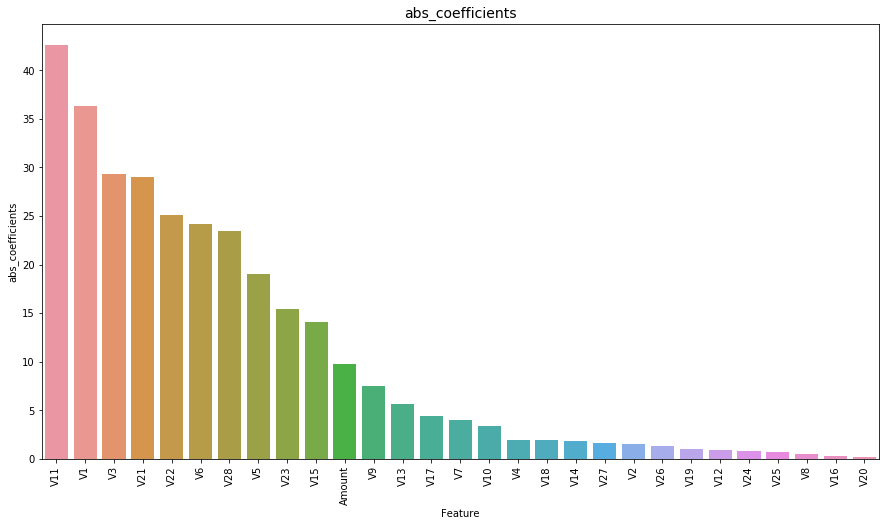

Precision is  0.8227848101265823
Recall is  0.7142857142857143
F1 score is  0.7647058823529411


In [12]:
#feature coefficient
features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9',
                                            'V10','V11','V12','V13','V14','V15','V16','V17','V18',
                                            'V19','V20','V21','V22','V23','V24','V25','V26','V27',
                                            'V28','Amount']
lr = LogisticRegression(featuresCol = 'features', labelCol='Class',threshold=0.2, maxIter=150)
lrModel = lr.fit(df_train)
coefficients = lrModel.coefficients
abs_coefficients=[abs(i) for i in coefficients]
tmp = pd.DataFrame({'Feature': features, 'abs_coefficients': abs_coefficients})
tmp = tmp.sort_values(by='abs_coefficients',ascending=False)
plt.figure(figsize = (15,8))
plt.title('abs_coefficients',fontsize=14)
s = sns.barplot(x='Feature',y='abs_coefficients',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

pred = lrModel.transform(df_test)
pred = pred.select("features", "Class", "rawPrediction", "prediction")
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)

# Step5. stratified cv using features selected from 4)
#### 'V11', 'V1','V21','V3','V22','V6','V28'

In [8]:

df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V11', 'V1','V21','V3','V22','V6','V28']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None',0, False, features, 'lr', [0.2],[150])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)
sqlContext.clearCache()

[0.2, 150]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847

 precision, recall, f_score: 0.8205128205128205, 0.5245901639344263, 0.64
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.7608695652173914, 0.5645161290322581, 0.6481481481481481
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.9024390243902439, 0.5967741935483871, 0.7184466019417476
train: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 0.84375, 0.43548387096774194, 0.5744680851063829

 precision, recall, f_score: 0.8918918918918919, 0.5409836065573771, 0.673469387755102
grid search precision: 0.8438926604024696
grid search recall: 0.5324695928080381
grid search f-score: 0.6529490041012765
grid search hyper: [0.2, 150]


# Step6. revisit step5 to choose best feature

#### 'V11', 'V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10'

In [15]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V11', 'V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None',0, False, features, 'lr', [0.2],[150])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)
sqlContext.clearCache()

[0.2, 150]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847

 precision, recall, f_score: 0.9090909090909091, 0.6557377049180327, 0.761904761904762
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.8775510204081632, 0.6935483870967742, 0.7747747747747746
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.8, 0.6451612903225806, 0.7142857142857142
train: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 0.8260869565217391, 0.6129032258064516, 0.7037037037037037

 precision, recall, f_score: 0.8333333333333334, 0.5737704918032787, 0.6796116504854368
grid search precision: 0.849212443870829
grid search recall: 0.6362242199894236
grid search f-score: 0.7274487534230674
grid search hyper: [0.2, 150]


#### 'V11','V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10','V4','V18','V14','V27','V2','V26','V19','V12','V24','V25','V8','V16'


In [18]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V11', 'V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10','V4','V18','V14','V27','V2','V26','V19','V12','V24','V25','V8','V16']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None',0, False, features, 'lr', [0.2],[150])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
sqlContext.clearCache()

[0.2, 150]
train: 145268
fraud ratio: 0.001700305641985847
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.7818181818181819, 0.6935483870967742, 0.7350427350427351

 precision, recall, f_score: 0.7307692307692307, 0.6229508196721312, 0.672566371681416
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.7352941176470589, 0.8064516129032258, 0.7692307692307693

 precision, recall, f_score: 0.8958333333333334, 0.6935483870967742, 0.7818181818181819
train: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 0.8372093023255814, 0.5901639344262295, 0.6923076923076923
grid search precision: 0.7961848331786773
grid search recall: 0.681332628239027
grid search f-score: 0.7342948142665915


# Step7. Using finalized features do stratified cv grid search for marginal improvement
#### finalized feature from step6: 'V11','V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10','V4','V18','V14','V27','V2','V26','V19','V12','V24','V25','V8','V16'




In [9]:
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V11', 'V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10','V4','V18','V14','V27','V2','V26','V19','V12','V24','V25','V8','V16']
gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'None', 0, False, features, 'lr', [0.1,0.15,0.2],[130,150,170])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)
sqlContext.clearCache()

[0.1, 130]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847

 precision, recall, f_score: 0.7352941176470589, 0.819672131147541, 0.7751937984496124

 precision, recall, f_score: 0.7540983606557377, 0.7419354838709677, 0.7479674796747967
train: 145266
fraud ratio: 0.0016934451282474908
train: 145266
fraud ratio: 0.0016934451282474908

 precision, recall, f_score: 0.7166666666666667, 0.6935483870967742, 0.7049180327868854

 precision, recall, f_score: 0.8148148148148148, 0.7096774193548387, 0.7586206896551724
train: 145270
fraud ratio: 0.0017002822330832244

 precision, recall, f_score: 0.84, 0.6885245901639344, 0.7567567567567568
[0.1, 150]
train: 145266
fraud ratio: 0.0016934451282474908
train: 145268
fraud ratio: 0.001700305641985847

 precision, recall, f_score: 0.7540983606557377, 0.7419354838709677, 0.7479674796747967

 precision, recall, f_score: 0.7575757575757576, 0.819672131147541, 0.7874015748031497
train: 145266
fraud ratio: 0.0

### Best hyper parameter after second grid search
#### grid search hyper: [0.1, 150]

# Step8
## use stratified cv to compare no sampling, undersampling, and oversampling


In [12]:
#undersampling with finalized features and best param from step7:[0.1,150]
df = sqlContext.read.csv("base_train.csv", header = True)
features = ['V11', 'V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10','V4','V18','V14','V27','V2','V26','V19','V12','V24','V25','V8','V16']
for i in [0.01, 0.05, 0.10, 0.20]:
    gs_hyper, gs_precision, gs_recall, gs_fscore = tune(df, 5, True, 'under', i, False, features, 'lr', [0.1],[150])
print("grid search precision:", gs_precision)
print("grid search recall:", gs_recall)
print("grid search f-score:", gs_fscore)
print("grid search hyper:", gs_hyper)
sqlContext.clearCache()

[0.1, 150]
train: 24700
fraud ratio: 0.01
train: 24600
fraud ratio: 0.01

 precision, recall, f_score: 0.5714285714285714, 0.8524590163934426, 0.6842105263157895

 precision, recall, f_score: 0.5434782608695652, 0.8064516129032258, 0.6493506493506493
train: 24600
fraud ratio: 0.01
train: 24600
fraud ratio: 0.01

 precision, recall, f_score: 0.6235294117647059, 0.8548387096774194, 0.7210884353741497

 precision, recall, f_score: 0.4049586776859504, 0.7903225806451613, 0.53551912568306
train: 24700
fraud ratio: 0.01

 precision, recall, f_score: 0.5531914893617021, 0.8524590163934426, 0.6709677419354838
[0.1, 150]
train: 4919
fraud ratio: 0.05001016466761537
train: 4939
fraud ratio: 0.05001012350678275

 precision, recall, f_score: 0.10707070707070707, 0.8548387096774194, 0.19030520646319568

 precision, recall, f_score: 0.09302325581395349, 0.9180327868852459, 0.1689291101055807
train: 4919
fraud ratio: 0.05001016466761537
train: 4919
fraud ratio: 0.05001016466761537

 precision, recall

### The results of oversampling and undersampling are not better than no sampling method

# Step9. Train base_train test base_test using hyperparams from 7)

In [14]:
#base model after feature selection

trainData = sqlContext.read.csv("base_train.csv", header = True)
testData = sqlContext.read.csv("base_test.csv", header = True)
trainData = trainData.select(*(F.col(c).cast("double").alias(c) for c in trainData.columns))
testData = testData.select(*(F.col(c).cast("double").alias(c) for c in testData.columns))
train_count = trainData.select("Class").count()
train_fraud_count = trainData.select("Class").where(trainData.Class == 1).count()
test_count = testData.select("Class").count()
features = ['V11', 'V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10','V4','V18','V14','V27','V2','V26','V19','V12','V24','V25','V8','V16']
vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_train = vectorAssembler.transform(trainData)
df_test = vectorAssembler.transform(testData)

lr = LogisticRegression(featuresCol = 'features', labelCol='Class', threshold=0.1, maxIter=150 )
lrModel = lr.fit(df_train)


pred = lrModel.transform(df_test)
pred = pred.select("features", "Class", "rawPrediction", "prediction")
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)

Precision is  0.782608695652174
Recall is  0.7912087912087912
F1 score is  0.7868852459016393


### result after second grid search with final best hyper param
#### Precision is  0.782608695652174
#### Recall is  0.7912087912087912
#### F1 score is  0.7868852459016393


# Step10. train base_train test oot using hyperparams from 8)

In [15]:
#base model after feature selection

trainData = sqlContext.read.csv("base_train.csv", header = True)
testData_oot = sqlContext.read.csv("oot.csv", header = True)
trainData = trainData.select(*(F.col(c).cast("double").alias(c) for c in trainData.columns))
testData_oot = testData_oot.select(*(F.col(c).cast("double").alias(c) for c in testData_oot.columns))
train_count = trainData.select("Class").count()
train_fraud_count = trainData.select("Class").where(trainData.Class == 1).count()
test_count_oot = testData_oot.select("Class").count()
features = ['V11', 'V1','V21','V3','V22','V6','V28','V5','V23','V15','Amount','V9','V13','V17','V7','V10','V4','V18','V14','V27','V2','V26','V19','V12','V24','V25','V8','V16']
vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features')
df_train = vectorAssembler.transform(trainData)
df_test_oot = vectorAssembler.transform(testData_oot)

lr = LogisticRegression(featuresCol = 'features', labelCol='Class', threshold=0.1, maxIter=150 )
lrModel = lr.fit(df_train)


pred = lrModel.transform(df_test_oot)
pred = pred.select("features", "Class", "rawPrediction", "prediction")
precision = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.prediction == 1.0).count()
recall = pred.filter(pred.Class == pred.prediction).filter(pred.Class == 1.0).count() / pred.filter(pred.Class == 1.0).count()
f1 = 2 * precision * recall /(precision + recall)
print("Precision is ", precision)
print("Recall is ", recall)
print("F1 score is ", f1)

Precision is  0.7285714285714285
Recall is  0.6891891891891891
F1 score is  0.7083333333333334


### extrapolation result
#### Precision is  0.7285714285714285
#### Recall is  0.6891891891891891
#### F1 score is  0.7083333333333334